In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import collections
import mglearn
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings(action='ignore') 

random.seed(2020)

In [6]:
# 데이터 정규화
def standardization(Data):
    Input = ((Data[['length','income']] - np.mean(Data[['length','income']], axis=0)) / np.std(Data[['length','income']], axis=0))
    return(pd.concat([Input, Data['label']], axis=1))

#데이터 로드
df=pd.read_csv('data/BitcoinHeistData.csv')

#데이터 전처리
le=LabelEncoder()
le.fit(df['label'])
df['label']=le.transform(df['label'])
df=standardization(df)
la=['length','income']
lb=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,28]

for i in range(len(la)):
    q1=df[la[i]].quantile(0.25)
    q2=df[la[i]].quantile(0.5)
    q3=df[la[i]].quantile(0.75)
    iqr=q3-q1
    condition=df[la[i]]>q3+1.5*iqr
    a=df[condition].index
    df.drop(a,inplace=True)

for i in range(len(lb)):
    a=df[df['label']==lb[i]].index
    df.drop(a,inplace=True)

In [272]:
#데이터 요약정보 프린트
def Data_Info(Data,NAME):
    print(NAME ,": ",np.shape(Data)[0],"/ Class : ",len(collections.Counter(np.array(Data)[:,2])))

Data_Info(df,'BitcoinHeistData')

BitcoinHeistData :  15825 / Class :  2


Text(0.5, 1.0, 'Data: BitcoinHeistData')

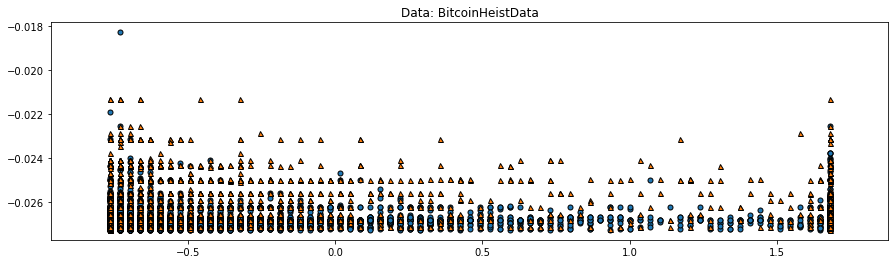

In [273]:
# 산점도 가시화
def Simple_Scatter(Data, Name):
    G = sns.jointplot(x = 'length', y = 'income', data = Data, kind='scatter', hue = 'label')
    G.fig.suptitle("Data : " + Name, fontsize = 10, color = 'black', alpha = 0.9)

# 가상의 데이터셋 3가지 그래프
fig, axes = plt.subplots(1,1,figsize=(15,4))
mglearn.discrete_scatter(df['length'], df['income'], df['label'], ax=axes, s=5)
axes.set_title("Data: BitcoinHeistData" )

In [206]:
# K-Means 클러스터링 함수 실행 후 차트 가시화
def k_Means_Plot(Data, Select_k, NAME, Init_Method = 'k-means++', Num_Init=10):
    Data2 = Data[['length', 'income']]    
    fig, axes = plt.subplots(1, (np.max(list(Select_k))-np.min(list(Select_k)))+1, figsize=(15, 4))
    for i in Select_k:
        Kmeans_Clustering = KMeans(n_clusters=i, init=Init_Method, random_state=2020, n_init=Num_Init)
        Kmeans_Clustering.fit(Data2)
        mglearn.discrete_scatter(Data2['length'], Data2['income'], Kmeans_Clustering.labels_, ax=axes[i - 2], s=5)
        mglearn.discrete_scatter(Kmeans_Clustering.cluster_centers_[:, 0], 
                                 Kmeans_Clustering.cluster_centers_[:, 1],
                                 list(range(i)), 
                                 markeredgewidth=3, 
                                 ax=axes[i - 2], s=10)
        Score = np.round(silhouette_score(Data2, Kmeans_Clustering.labels_),3)
        axes[i - 2].set_title( NAME + ' / k = ' + str(i)+' / S_Score:'+str(Score))

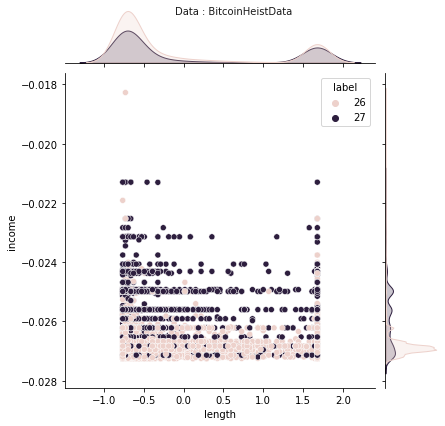

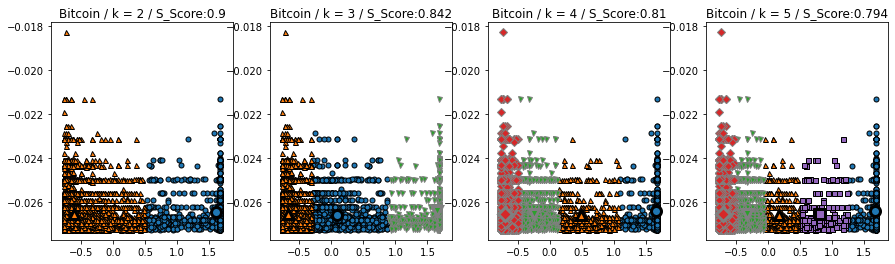

In [207]:
Simple_Scatter(df, 'BitcoinHeistData')
    
k_Means_Plot(Data = df,Select_k = range(2, 6),NAME = 'Bitcoin',Init_Method='random',Num_Init=1)

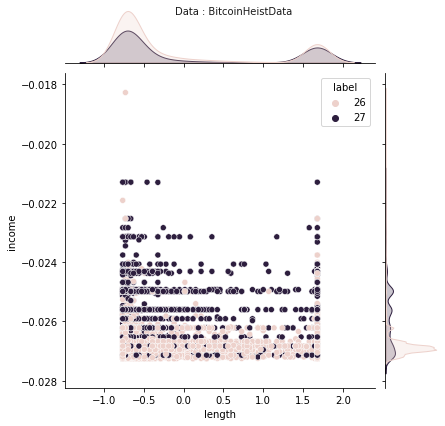

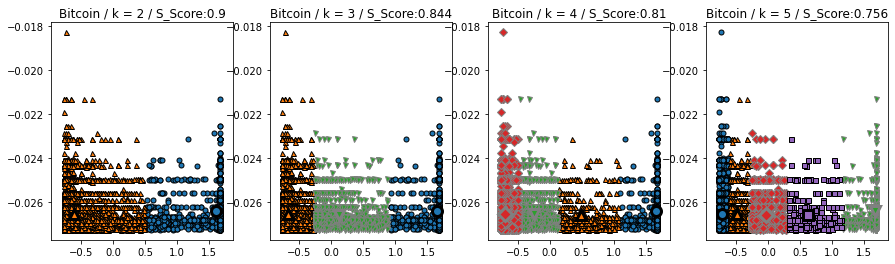

In [208]:
Simple_Scatter(df, 'BitcoinHeistData')
    
k_Means_Plot(Data = df,Select_k = range(2, 6),NAME = 'Bitcoin',Init_Method='random',Num_Init=10)

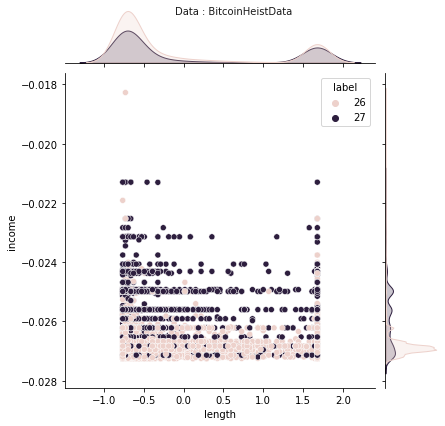

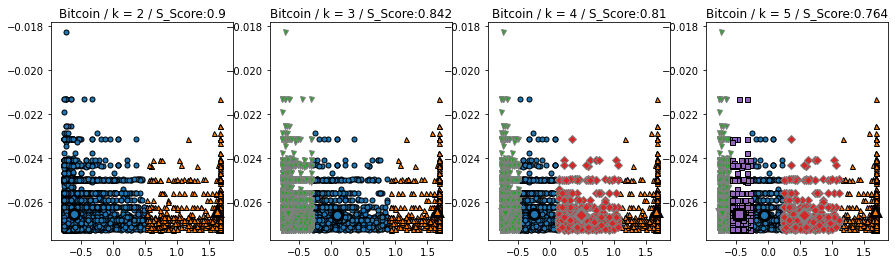

In [209]:
Simple_Scatter(df, 'BitcoinHeistData')
    
k_Means_Plot(Data = df,Select_k = range(2, 6),NAME = 'Bitcoin',Init_Method='k-means++',Num_Init=1)

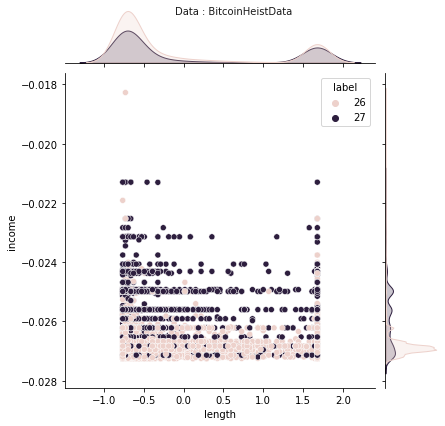

In [210]:
# Well seperated dataset
Simple_Scatter(df, 'BitcoinHeistData')

def Fixed_Dendrogram(Data, Num_of_p, Full_Use):
    Linkage_Matrix = linkage(Data,'complete')
    if(Full_Use == True):
        Num_of_p = np.shape(Data)[0]
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index')
    else:
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
    plt.ylabel('distance')
    dendrogram(
        Linkage_Matrix,
        truncate_mode = 'lastp',  
        p = Num_of_p, 
        leaf_rotation = 90.,
        leaf_font_size = 12.,
        color_threshold = 'default'
    )
    plt.show()

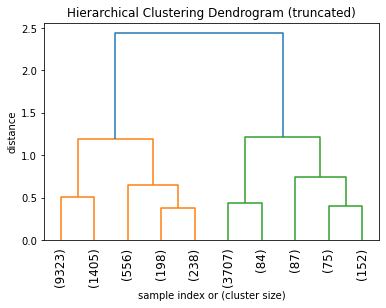

In [211]:
a = Fixed_Dendrogram(df[['length','income']], 10, False)

In [212]:
def Hclust_Plot(Data,Select_k,NAME):
    Data2 = Data[['length', 'income']]    
    fig, axes = plt.subplots(1, (np.max(list(Select_k))-np.min(list(Select_k)))+1, figsize=(15, 4))
    for i in Select_k:
        H_Clustering = AgglomerativeClustering(n_clusters=i,linkage="complete")
        P_Labels = H_Clustering.fit_predict(Data2)
        mglearn.discrete_scatter(Data2['length'], Data2['income'], P_Labels, ax=axes[i - 2], s=5)        
        axes[i - 2].set_title("Data:" + NAME + ' / k = ' + str(i))
        Score=np.round(silhouette_score(Data2,P_Labels),3)
        axes[i - 2].set_title( NAME + ' / k = ' + str(i)+' / S_Score:'+str(Score))

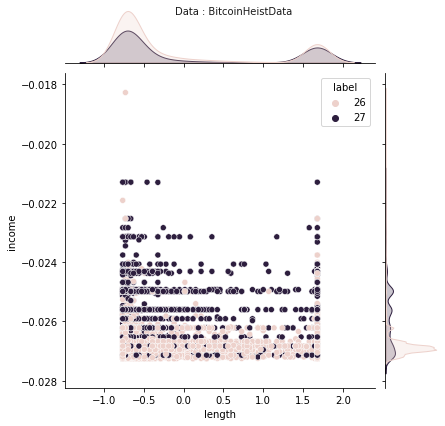

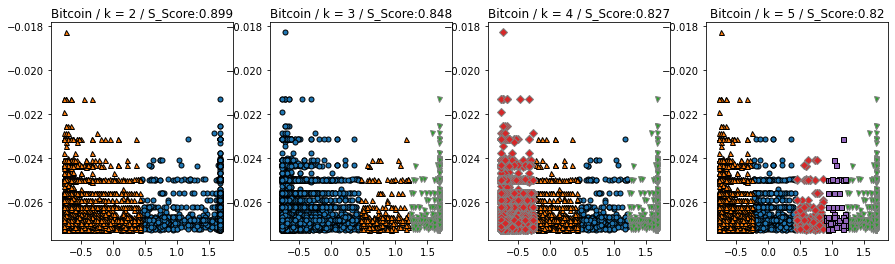

In [213]:
Simple_Scatter(df, 'BitcoinHeistData')
Hclust_Plot(df,range(2, 6),'Bitcoin')

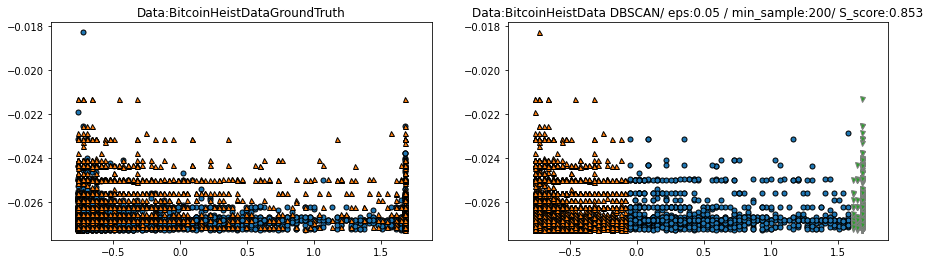

In [288]:
def DBSCAN_Plot(Data,NAME,min_samples=200,eps=0.05):
    Data2 = Data[['length', 'income']]
    Append_k_Means_Results = list()
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    Set_DBSCAN_Hyperparameter=DBSCAN(min_samples=min_samples,eps=eps)
    Results = Set_DBSCAN_Hyperparameter.fit_predict(Data2)
    Score=np.round(silhouette_score(Data2,Results),3)
    mglearn.discrete_scatter(Data2['length'], Data2['income'], Data['label'], ax=axes[0], s=5)
    axes[0].set_title("Data:" + NAME + 'GroundTruth')    
    mglearn.discrete_scatter(Data2['length'], Data2['income'], Results, ax=axes[1], s=5)
    axes[1].set_title("Data:" + NAME + ' DBSCAN/ eps:'+str(eps)+' / min_sample:'+str(min_samples)+'/ S_score:'+str(Score))

DBSCAN_Plot(Data=df,NAME='BitcoinHeistData')

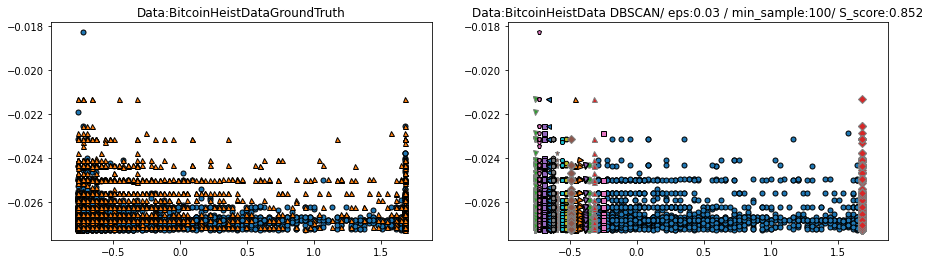

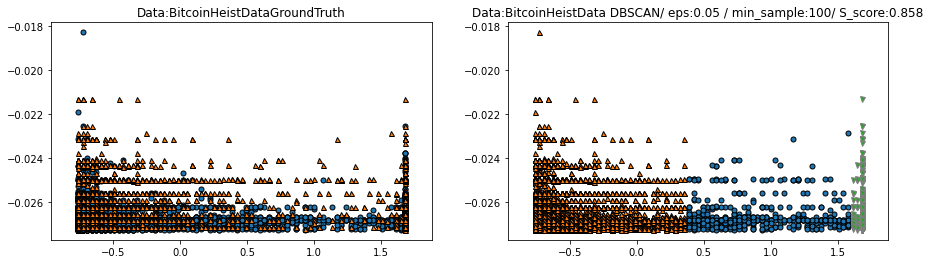

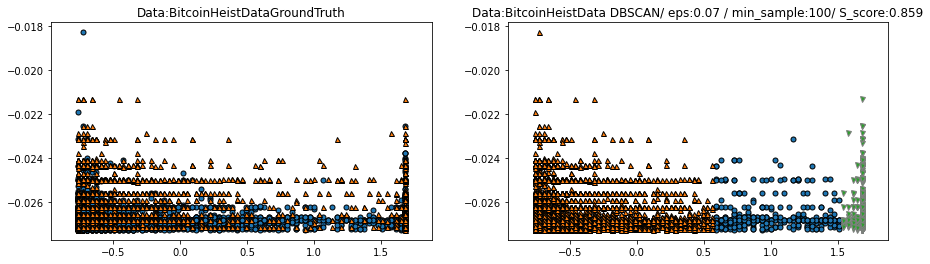

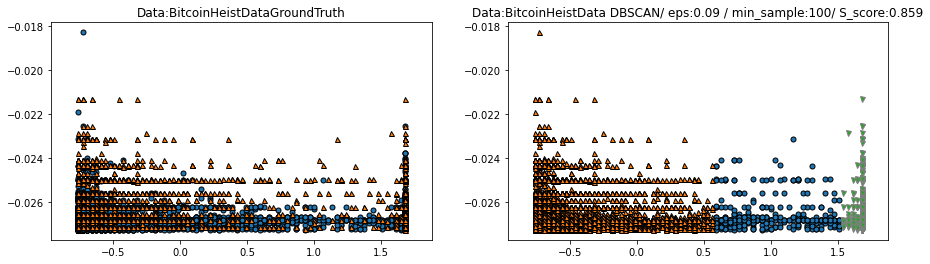

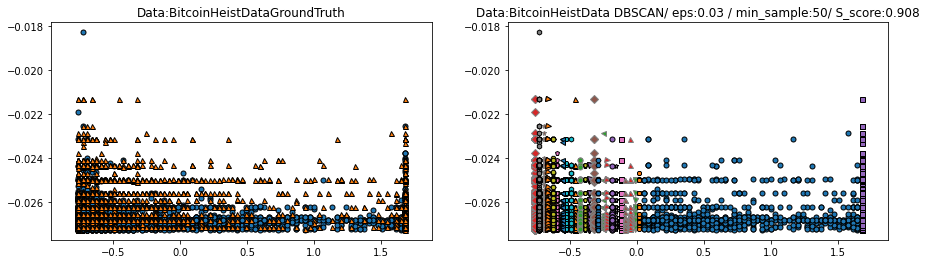

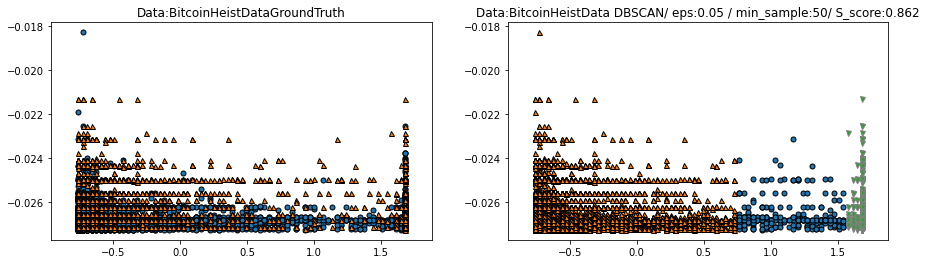

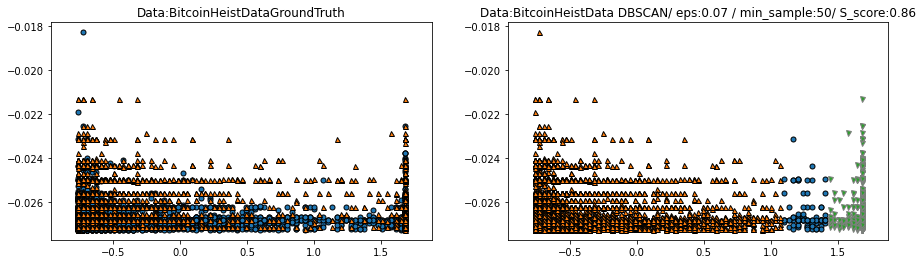

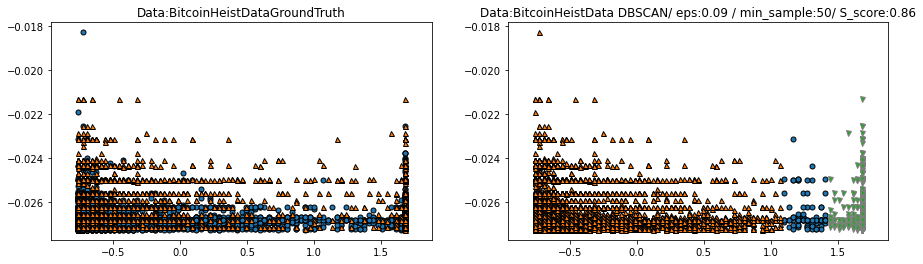

In [298]:
DBSCAN_Plot(Data=df,NAME="BitcoinHeistData",min_samples=100,eps=0.03)
DBSCAN_Plot(Data=df,NAME="BitcoinHeistData",min_samples=100,eps=0.05)
DBSCAN_Plot(Data=df,NAME="BitcoinHeistData",min_samples=100,eps=0.07)
DBSCAN_Plot(Data=df,NAME="BitcoinHeistData",min_samples=100,eps=0.09)
DBSCAN_Plot(Data=df,NAME="BitcoinHeistData",min_samples=50,eps=0.03)
DBSCAN_Plot(Data=df,NAME="BitcoinHeistData",min_samples=50,eps=0.05)
DBSCAN_Plot(Data=df,NAME="BitcoinHeistData",min_samples=50,eps=0.07)
DBSCAN_Plot(Data=df,NAME="BitcoinHeistData",min_samples=50,eps=0.09)

In [2]:
# 라이브러리 로드
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer # 사용할 dataset (유방암데이터)
from sklearn.model_selection import train_test_split # 학습, 테스트set 구분
from sklearn.tree import export_graphviz # tree 시각화를 위해
# export_graphviz : 의사결정나무에 대한 graphviz dot data 생성하는 함수
import graphviz # tree 시각화
import sklearn.metrics as mt # 성능지표를 계산하기 위해 import
from sklearn.model_selection import cross_val_score, cross_validate # 교차검증

import warnings
warnings.filterwarnings('ignore')

In [13]:
#데이터 로드, 결측치 제거
df2=pd.read_csv('data/titanic.csv')
df2.dropna(inplace=True)

lc=['Sex','Embarked']
le=LabelEncoder()
for i in range(len(lc)):
    le.fit(df2[lc[i]])
    df2[lc[i]]=le.transform(df2[lc[i]])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,2
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,2
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",0,4.0,1,1,PP 9549,16.7000,G6,2
11,12,1,1,"Bonnell, Miss. Elizabeth",0,58.0,0,0,113783,26.5500,C103,2
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",0,47.0,1,1,11751,52.5542,D35,2
872,873,0,1,"Carlsson, Mr. Frans Olof",1,33.0,0,0,695,5.0000,B51 B53 B55,2
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",0,56.0,0,1,11767,83.1583,C50,0
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,112053,30.0000,B42,2


In [14]:
seed = 5764

# 학습, 테스트 데이터 분리 (0.7:0.3)
x_train, x_test, y_train, y_test = train_test_split(df2[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']], df2.iloc[:,1], test_size=0.7, random_state=seed)

In [15]:
#의사결정나무 모델 구축
dt_clf = DecisionTreeClassifier(random_state=5764)
dt_clf.fit(x_train, y_train) # 학습

DecisionTreeClassifier(random_state=5764)

In [18]:
#의사결정나무 모델 가시화
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성
export_graphviz(dt_clf, out_file="tree.dot", class_names = (str)(df2['Survived'].value_counts()), feature_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], impurity=True, filled=True)

[ max_depth의 제약이 없는 경우의 Decision Tree 시각화 ]


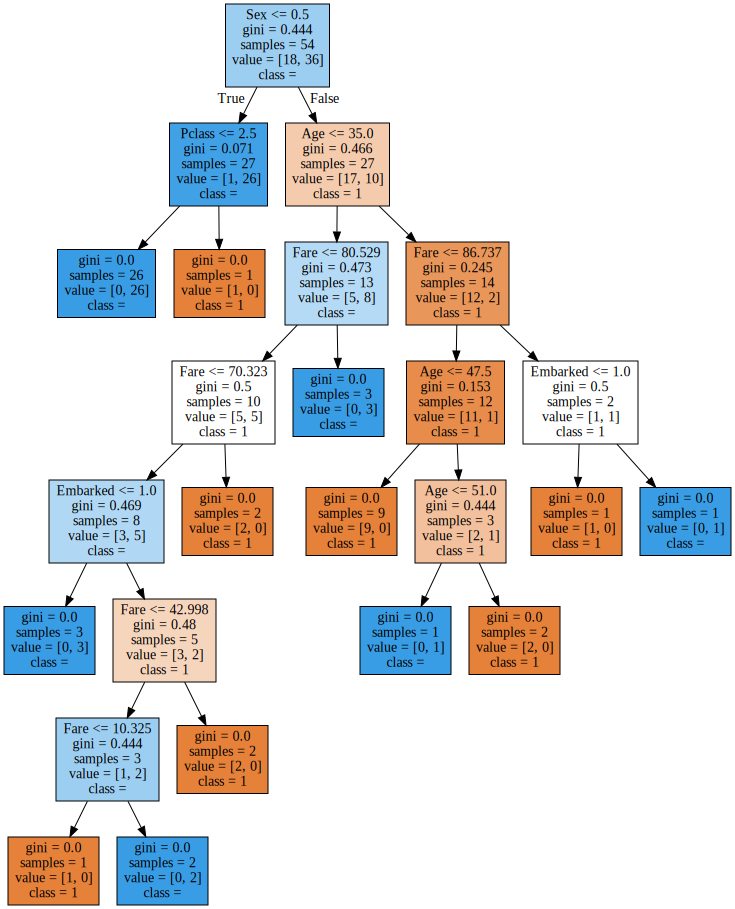

In [19]:
print('[ max_depth의 제약이 없는 경우의 Decision Tree 시각화 ]')
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [20]:
y_pred = dt_clf.predict(x_test) 

In [21]:
# 학습결과 평가
print("Train_Accuracy : ", dt_clf.score(x_train, y_train), '\n')
print("Test_Accuracy : ", dt_clf.score(x_test, y_test), '\n')

accuracy = mt.accuracy_score(y_test, y_pred)
recall = mt.recall_score(y_test, y_pred)
precision = mt.precision_score(y_test, y_pred)
f1_score = mt.f1_score(y_test, y_pred)
matrix = mt.confusion_matrix(y_test, y_pred)

print('Accuracy: ', format(accuracy,'.2f'),'\n')
print('Recall: ', format(recall,'.2f'),'\n')
print('Precision: ', format(precision,'.2f'),'\n')
print('F1_score: ', format(f1_score,'.2f'),'\n')
print('Confusion Matrix:','\n', matrix)

Train_Accuracy :  1.0 

Test_Accuracy :  0.751937984496124 

Accuracy:  0.75 

Recall:  0.78 

Precision:  0.84 

F1_score:  0.81 

Confusion Matrix: 
 [[29 13]
 [19 68]]


In [22]:
# 교차검증

x = df2[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = df2.iloc[:,1]

# 각 폴드의 스코어 
scores = cross_val_score(dt_clf, x, y, cv = 5)

print('Averaged results of cross validation: ', scores.mean())

Averaged results of cross validation:  0.7484984984984985


In [23]:
pd.DataFrame(cross_validate(dt_clf, x, y, cv =5))

,fit_time,score_time,test_score
0,0.002002,0.001,0.729730
1,0.002000,0.001,0.810811
2,0.002001,0.001,0.729730
3,0.003001,0.001,0.611111
4,0.002001,0.001,0.861111


In [24]:
# test set에 대한 스코어(정확도)
dt_clf.score(x_test, y_test)

0.751937984496124

In [25]:
pruned_dt_clf = DecisionTreeClassifier(max_depth=2, random_state=156) # max_depth=3으로 제한
pruned_dt_clf .fit(x_train, y_train)

print("Accuracy of training set: {:.3f}".format(pruned_dt_clf.score(x_train, y_train)))
print("Accuracy of test set: {:.3f}".format(pruned_dt_clf.score(x_test, y_test)))

Accuracy of training set: 0.870
Accuracy of test set: 0.736


In [26]:
# export_graphviz( )의 호출 결과로 out_file로 지정된 tree.dot 파일을 생성함
export_graphviz(pruned_dt_clf, out_file="prunedtree.dot", class_names = (str)(df2['Survived'].value_counts()), feature_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], impurity=True, filled=True)

[ max_depth가 2인 경우의 Decision Tree 시각화 ]


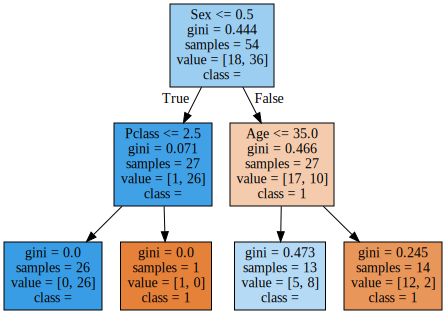

In [27]:
print('[ max_depth가 2인 경우의 Decision Tree 시각화 ]')
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("prunedtree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)